# Removing inconsistent columns and outliers

In [35]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# flights table
flights_raw = pd.read_csv('/Users/Matthew Wong/flights_table(50,000_points).csv',delimiter=';')
data = flights_raw.iloc[: , 1:]

In [37]:
display(data.head())
display(data.shape)
display(data.columns)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-12-30,WN,WN,WN,775,WN,N255WN,775,13495,MSY,...,674.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-08,AS,AS,AS,352,AS,N464AS,352,14747,SEA,...,672.0,0.0,0.0,25.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2018-11-21,DL,DL,DL,1312,DL,N912DL,1312,10994,CHS,...,259.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-12-19,WN,WN,WN,1967,WN,N7820L,1967,11697,FLL,...,994.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-09-21,UA,UA_CODESHARE,UA,3908,ZW,N420AW,3908,14574,ROA,...,530.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(50000, 42)

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

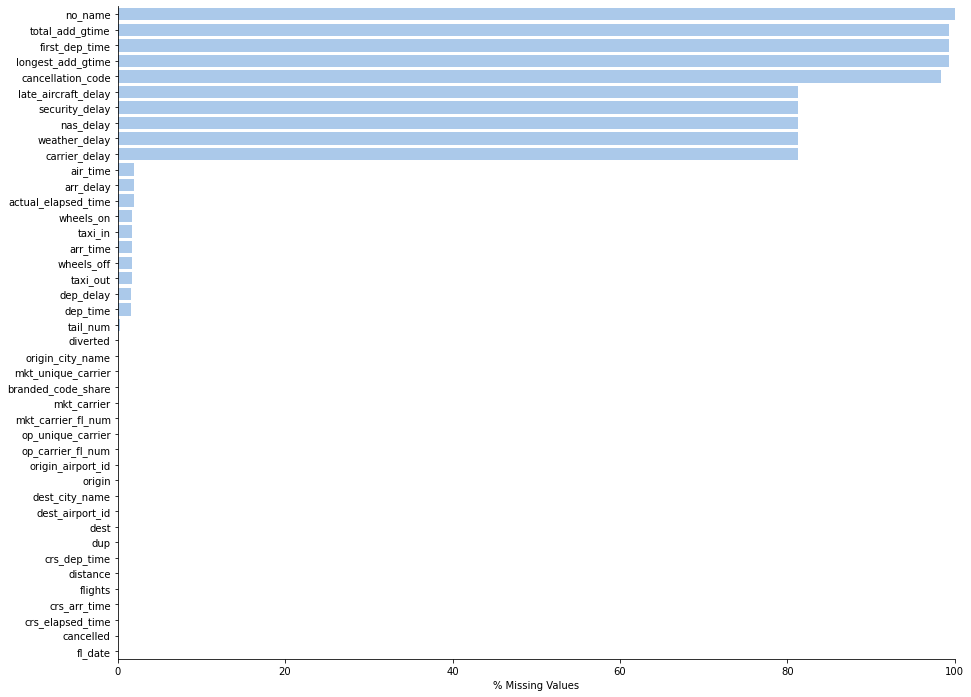

In [38]:
#plotting the percentage of missing values in each column
data_length = len(data)
data_null = (data.isnull().sum().sort_values(ascending=False)*100/len(data))
f, ax = plt.subplots(figsize=(15, 12))
sns.set_color_codes("pastel")
sns.set_color_codes("pastel")
ax.set(xlim=(0, 100), ylabel="",
       xlabel="% Missing Values")
sns.barplot(x=data_null.values, y=data_null.index, color="b")
sns.despine()

In [40]:
# drop all cancelled and diverted flights
filter1 = (data['cancelled']!=1) & (data['diverted']!=1)
data = data[filter1]

# drop outliers
data = data[(data['arr_delay']<50) & (data['arr_delay']>-50)]
data = data[(data['dep_delay']<50) & (data['dep_delay']>-50)]

# drop rows where theres no airtime
data.drop(data.loc[data['air_time'].isnull()].index,inplace=True)

# Feature Engineering

In [41]:
#Adding date time features and state
data['month'] = pd.DatetimeIndex(data['fl_date']).month
data['year'] = pd.DatetimeIndex(data['fl_date']).year
data['day'] = pd.DatetimeIndex(data['fl_date']).day
data['origin_city_state'] = data['origin_city_name'].transform(lambda x: str(x).split(',')[1])
data['origin_city'] = data['origin_city_name'].transform(lambda x: str(x).split(',')[0])
data['dest_city_state'] = data['dest_city_name'].transform(lambda x: str(x).split(',')[1])
data['dest_city'] = data['dest_city_name'].transform(lambda x: str(x).split(',')[0])
data['depart_hour'] = data['dep_time'].round(-2)

# Add key features
data['Route'] = data['origin_city'] + ' to ' + data['dest_city']

data['dep_delay_route'] = data[['dep_delay','Route']].groupby(by='Route').transform(lambda x: x.mean())
data['arr_delay_route'] = data[['arr_delay','Route']].groupby(by='Route').transform(lambda x: x.mean())
data['taxi_out_route'] = data[['taxi_out','Route']].groupby(by='Route').transform(lambda x: x.mean())
data['taxi_in_route'] = data[['taxi_in','Route']].groupby(by='Route').transform(lambda x: x.mean())

data['dep_delay_city'] = data[['dep_delay','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())
data['arr_delay_city'] = data[['arr_delay','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())
data['taxi_out_city'] = data[['taxi_out','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())
data['taxi_in_city'] = data[['taxi_in','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())

data['dep_delay_month'] = data[['dep_delay','month']].groupby(by='month').transform(lambda x: x.mean())
data['arr_delay_month'] = data[['arr_delay','month']].groupby(by='month').transform(lambda x: x.mean())
data['taxi_out_month'] = data[['taxi_out','month']].groupby(by='month').transform(lambda x: x.mean())
data['taxi_in_month'] = data[['taxi_in','month']].groupby(by='month').transform(lambda x: x.mean())

#drop columns
data = data[['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance',
             'air_time','depart_hour','dep_delay_route','arr_delay_route','taxi_out_route','taxi_in_route',
             'dep_delay_city','arr_delay_city','taxi_out_city','taxi_in_city','dep_delay_month','arr_delay_month',
             'taxi_out_month','taxi_in_month','arr_delay']]

# Encoding and removing missing data

In [45]:
# Encode Cateogircal Values 
# Change dtype of variable to category then encode using cat.codes
data['origin_city_state'] = data['origin_city_state'].astype('category')
data['origin_city'] = data['origin_city'].astype('category')
data['dest_city_state'] = data['dest_city_state'].astype('category')
data['dest_city'] = data['dest_city'].astype('category')
data['Route'] = data['Route'].astype('category')

data['origin_city_state'] = data['origin_city_state'].cat.codes
data['origin_city'] = data['origin_city'].cat.codes
data['dest_city_state'] = data['dest_city_state'].cat.codes
data['dest_city'] = data['dest_city'].cat.codes
data['Route'] = data['Route'].cat.codes

In [46]:
# missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

display(missing_data.head(20))
display(data.shape)

,Total,Percent
arr_delay,0,0.0
taxi_in_month,0,0.0
day,0,0.0
year,0,0.0
origin_city,0,0.0
origin_city_state,0,0.0
dest_city,0,0.0
dest_city_state,0,0.0
Route,0,0.0
distance,0,0.0


(44551, 24)

In [47]:
#drop null values and duplicates if any
data = data.dropna()
data.drop_duplicates()
display(data.head())
display(data.shape)
display(data.columns)

,month,day,year,origin_city,origin_city_state,dest_city,dest_city_state,Route,distance,air_time,...,taxi_in_route,dep_delay_city,arr_delay_city,taxi_out_city,taxi_in_city,dep_delay_month,arr_delay_month,taxi_out_month,taxi_in_month,arr_delay
0,12,30,2019,220,17,105,8,2987,674.0,84.0,...,8.444444,1.710611,-4.176849,11.800643,8.057878,0.892546,-5.488575,17.429543,7.718988,-3.0
1,4,8,2018,296,49,233,4,4370,672.0,98.0,...,6.208333,1.014692,-4.634527,19.509642,6.965106,-0.045202,-5.727201,16.802538,7.431139,25.0
2,11,21,2018,52,40,17,9,604,259.0,46.0,...,10.238095,-1.163522,-7.421384,14.861635,8.779874,0.093850,-5.732620,16.940107,7.404545,-13.0
3,12,19,2019,103,8,249,37,1730,994.0,128.0,...,5.333333,1.163701,-4.740214,17.135231,7.814947,0.892546,-5.488575,17.429543,7.718988,-16.0
4,9,21,2019,267,46,61,13,3848,530.0,82.0,...,10.666667,1.934783,-4.913043,18.152174,8.673913,-0.826970,-6.525318,16.681560,7.540753,-36.0


(44551, 24)

Index(['month', 'day', 'year', 'origin_city', 'origin_city_state', 'dest_city',
       'dest_city_state', 'Route', 'distance', 'air_time', 'depart_hour',
       'dep_delay_route', 'arr_delay_route', 'taxi_out_route', 'taxi_in_route',
       'dep_delay_city', 'arr_delay_city', 'taxi_out_city', 'taxi_in_city',
       'dep_delay_month', 'arr_delay_month', 'taxi_out_month', 'taxi_in_month',
       'arr_delay'],
      dtype='object')

In [48]:
# save as csv
data.to_csv(r'/Users/Matthew Wong/flights_table_optimized(50,000 points).csv',sep=';') # change 'data' to choose location to save csv